In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Transformer

/content/drive/MyDrive/Transformer


In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tqdm import tqdm
from encoders.apply_bpe import BPE
import os

In [4]:
#from dataset import *
from Transformer import *
from dataset import *

In [5]:
vocab_size = 5374 + 2
embedding_size = 64
d_k = 8
words = 64
total_lines = 100
codec_file = open("datasets/english_codec.txt", encoding = 'utf-8')

In [6]:
dataset = Dataset("datasets/english_dataset.txt", "datasets/hindi_dataset.txt", total_lines = 10000)

Primary Language Tokens: 5195
Secondary Language Tokens: 5374


In [7]:
dataset.create_dataset()

100%|██████████| 10000/10000 [00:00<00:00, 10243.45it/s]


Total Lines added: 144315


In [8]:
training_data = tf.data.Dataset.from_tensor_slices(((dataset.encoder_inputs, dataset.decoder_inputs), dataset.output_vectors))

In [9]:
def create_model():
    encoder_input = tf.keras.layers.Input((words))
    decoder_input = tf.keras.layers.Input((words))
    
    encoder_embeddings = tf.keras.layers.Embedding(vocab_size + 2, embedding_size)(encoder_input)
    decoder_embeddings = tf.keras.layers.Embedding(vocab_size + 2, embedding_size)(decoder_input)
    
    enc_pos = PositionalEmbedding(embedding_size = embedding_size, words = words)(encoder_embeddings)
    dec_pos = PositionalEmbedding(embedding_size = embedding_size, words = words)(decoder_embeddings)
    
    encoder_outputs1 = Encoder(d_k = d_k, model_embedding = embedding_size)(enc_pos)
    decoder_outputs1 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((dec_pos, encoder_outputs1[0], encoder_outputs1[1]))

    encoder_outputs2 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs1[1])
    decoder_outputs2 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs1, encoder_outputs2[0], encoder_outputs2[1]))

    encoder_outputs3 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs2[1])
    decoder_outputs3 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs2, encoder_outputs3[0], encoder_outputs3[1]))

    encoder_outputs4 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs3[1])
    decoder_outputs4 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs3, encoder_outputs4[0], encoder_outputs4[1]))

    encoder_outputs5 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs4[1])
    decoder_outputs5 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs4, encoder_outputs5[0], encoder_outputs5[1]))

    encoder_outputs6 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs5[1])
    decoder_outputs6 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs5, encoder_outputs6[0], encoder_outputs6[1]))

    encoder_outputs7 = Encoder(d_k = d_k, model_embedding = embedding_size)(encoder_outputs6[1])
    decoder_outputs7 = Decoder(input_words = words, model_embedding = embedding_size, d_k = d_k)((decoder_outputs6, encoder_outputs7[0], encoder_outputs7[1]))
    
    
    decoder_outputs = tf.keras.layers.Flatten()(decoder_outputs7)
    decoder_outputs = tf.keras.layers.Dense(vocab_size)(decoder_outputs)
    
    output = tf.nn.softmax(decoder_outputs)
    
    model = tf.keras.Model(inputs = [encoder_input, decoder_input], outputs=[output])
    
    return model

In [10]:
model = create_model()
model.summary()

(None, 64, 64)
(None, 64, 64)
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([No

In [11]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [12]:
strategy = tf.distribute.TPUStrategy(resolver)

In [13]:
with strategy.scope():
    model = create_model()
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.01))
    
    history = model.fit((dataset.encoder_inputs, dataset.decoder_inputs), dataset.output_vectors, batch_size = 1024, epochs = 10)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.001))

    history = model.fit((dataset.encoder_inputs, dataset.decoder_inputs), dataset.output_vectors, batch_size = 1024, epochs = 150)
    

(None, 64, 64)
(None, 64, 64)
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(None, 64, 64)
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([None, 64, 64]), TensorShape([None, 64, 64]))
(TensorShape([None, 64, 64]), TensorShape([No

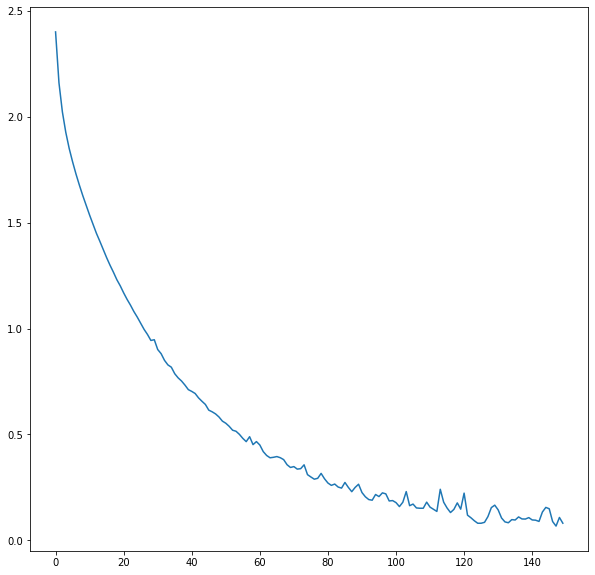

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])

In [24]:
key = "politicians do not have permission to do what needs to be done."

In [25]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[ 244 2417 1627 2881  529 2267 3070 1796 1627 1792 5144 1796  121 5177
  2912    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:29<00:00,  4.21s/it]



राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कि कि रहा कि न है करना , प्रकार वह होते हैं | हैं सकती है चाहिए । चाहिए । चाहिए चाहिए . . . . है । । । . . . . है । . . . । । . । . । । । । । । । ।


In [26]:
key = "This percentage is even greater than the percentage in India."

In [27]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[ 990 1923 4688 1156 5134 2208  968  967 1923 4688 1538 2662    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:26<00:00,  4.17s/it]



यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। की है। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं।


In [28]:
key = "humans destroyed the commons that they depended on."

In [29]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[4478 2417 4946 1744  967 4787 2507  154 1675 3107 5107  230    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:10<00:00,  3.91s/it]



मानवों ने उन ही साझे संसाधनों को नष्ट किया जिन पर वो आधारित थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे। थे।


In [30]:
key = "Sanskrit is world's oldest language of vedas."

In [31]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[3872 1156 3169 2997 3332 2890  243 1585  839  928    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:15<00:00,  4.00s/it]



संस्कृत वका सेसेसेसेसेसेलिए में करें ही... ... ... ... ... ... ... ... ... हीहै। | है। है। है। नाम है। शामिल हैं है। है। है। है। शामिल है. है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। है। | है। | रहे रहे


In [34]:
key = "In Indian culture, Holy texts have a special importance, and the Purans are among the most important of all the holy texts."

In [35]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[3165 2661 1595  231 4623 3252 4948 4396  529 2833 1649 1973 2585  877
   967 4259 2417 3754 3126  967 3193 3609 1585 1697  967 3870 4948 1277
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:29<00:00,  4.22s/it]



भारतीय जीवन-धारा में जिन ग्रन्थों का महत्वपूर्ण स्थान है उनमें पुराण भक्ति-ग्रंथों के रूप में बहुत महत्वपूर्ण माने जाते हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं।


In [39]:
key = "In Indian culture, Holy texts are written in Sanskrit language in greater percentage"

In [40]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[3165 2661 1595  231 4623 3252 4948 4396 3754 4395 1538 3872  243 1538
  2208 1923 4688    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:16<00:00,  4.00s/it]



भारतीय आयु संस्कृत बिप्राप्त की के तततहो ही | होना है के दो तथा बी बी दो दो दो दो है, | है . और . . . और . और पर . और . . भी पर . पर करने . ) है . . . . . . . . . . . . . . . .


In [41]:
key = "India and China are countries in Asia"

In [42]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[2844  877  399 3754  690 1538 1373 2833    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:07<00:00,  3.86s/it]



और और याही ों एक एक मयामममजुभर भर है, है, है हैं हूँ, हूँ, । । कोहै। सहेकोहै। है। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। हैं। । । । । । । । ।


In [43]:
key = "Ancient Sanskrit literature is extremely old, vast and diverse"

In [44]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[ 118 4644 3872  368 1156 1619  533    6 3003  877 1903 4402    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:20<00:00,  4.07s/it]



संस्कृत का प्राचीन साहित्य अत्यन्त प्राचीन विशाल और विविधतापूर्ण है। है। है। है। है। है। है। है। में है। है। है। है। है। है। है. है. की है. दीहै. है. है. टटहै. है. में है. है. हुए ते है. से है. है. है. है. है. है. है. है. है. है. है. है. है. है. है. है. है. है.


In [45]:
key = "Ancient Sanskrit literature is extremely old religious creations in Hindi."

In [46]:
bpe_obj = BPE(codes = codec_file)
key = bpe_obj.process_line(key)

encoding = dataset.primary_vectorizer(key).numpy().reshape(1, 64)
print(encoding)
decoding = np.zeros(shape=(1, 64))

for i in tqdm(range(64)):
    decoding[0, i] = tf.argmax(model((decoding, encoding)), -1)

decoding = tf.convert_to_tensor(decoding)
translation = dataset.convert_to_secondary(decoding)
print("\n")
print(translation.replace('@@ ', ''))

[[ 118 4644 3872  368 1156 1619 1222 4730 4923 1118 1538 1212 2062    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


100%|██████████| 64/64 [04:32<00:00,  4.26s/it]



संस्कृत एक दूसरा पूर्ण सहायता सहायता सम्का बोउपयोग उपयोग का ों स्ट है। का है। है। है। है। है। है। है। है। है। है। की होती है। ध्यान का है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है| है। है। है। है। है। है। है। है। है। है। है। है। है।
